# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("/datasets/real_estate_data.csv",sep="\t")
pd.set_option('max_columns', None)
#изучение данных в таблице
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 23699 entries, 0 to 23698

Data columns (total 22 columns):

 #   Column                Non-Null Count  Dtype  

---  ------                --------------  -----  

 0   total_images          23699 non-null  int64  

 1   last_price            23699 non-null  float64

 2   total_area            23699 non-null  float64

 3   first_day_exposition  23699 non-null  object 

 4   rooms                 23699 non-null  int64  

 5   ceiling_height        14504 non-null  float64

 6   floors_total          23613 non-null  float64

 7   living_area           21796 non-null  float64

 8   floor                 23699 non-null  int64  

 9   is_apartment          2775 non-null   object 

 10  studio                23699 non-null  bool   

 11  open_plan             23699 non-null  bool   

 12  kitchen_area          21421 non-null  float64

 13  balcony               12180 non-null  float64

 14  locality_name         23650 non-null  object 

 15 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Из информации о датафрейме можно сделать следующие выводы:  
В данных много пропусков, особенно в информации об апартаментах, расстоянии до водоемов и парков. Чуть меньше половины квартир не имеют данных о высоте потолка. Также необходимо привести дату опубликования объявления к типу даты, целочисленные величины (количество водоемов и парков в радиусе 3 км, время продажи, количество балконов, общее количество этажей к целочисленному типу). 


array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

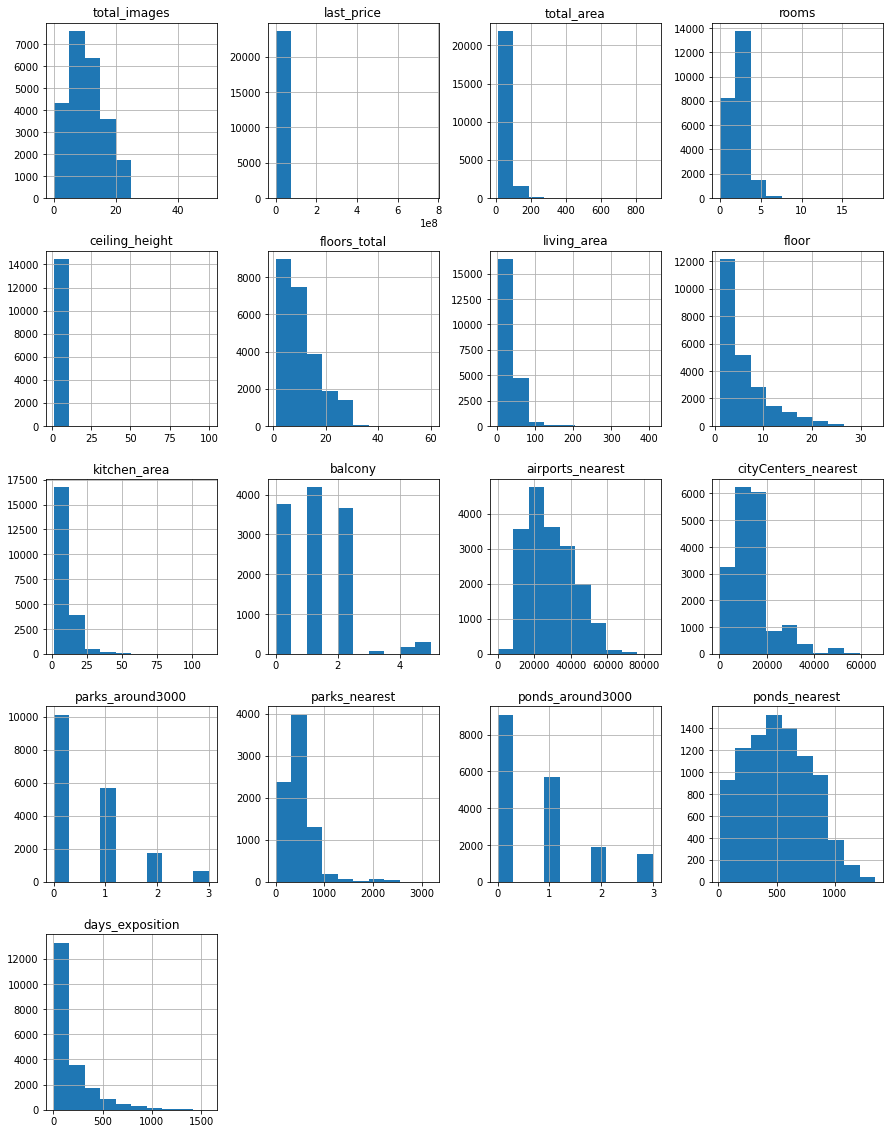

In [3]:
data.hist(figsize=(15, 20))

Из графиков можно сделать следующие выводы:  
В датафрейме преобладают объекты площадью до 100 квадратов до 4 комнат, с высотой потолков до 3 м в домах до 20 этажей. Большинство их них продаются за 100 дней. Прмерно 30% объектов не имеют водоемов в радиусе 3 км, примерно 45% не имеют парков в том же радиусе. На гистограмме высот потолков сразу видно аномельные значения (до 100 м).


## Предобработка данных

In [4]:
#Проверка данных на пропуски (сколько всего пропущено и соотношение пропусков к общему количеству)

print(data.isna().sum())
print(data.isna().sum()/len(data)*100)


total_images                0

last_price                  0

total_area                  0

first_day_exposition        0

rooms                       0

ceiling_height           9195

floors_total               86

living_area              1903

floor                       0

is_apartment            20924

studio                      0

open_plan                   0

kitchen_area             2278

balcony                 11519

locality_name              49

airports_nearest         5542

cityCenters_nearest      5519

parks_around3000         5518

parks_nearest           15620

ponds_around3000         5518

ponds_nearest           14589

days_exposition          3181

dtype: int64

total_images             0.000000

last_price               0.000000

total_area               0.000000

first_day_exposition     0.000000

rooms                    0.000000

ceiling_height          38.799105

floors_total             0.362885

living_area              8.029875

floor                   

Больше пропусков наблюдается в столбцах: высота потолка, является ли недвижимость апартаментами, количество балконов, расстояние до ближайших парков и прудов. Причем можно заметить, что хотя у недвижимости указано наличие парка или водоема в радиусе 3 км , данных о конкретном расстоянии нет у примерно 40% объектов.
Также пропуски присутствуют в столбцах: количество эатжей в доме, площадь жилой зоны, площадь кухни, название населенного пункта, расстояние до аэропорта, расстояние до центра, количество парков и прудов в радиусе 3 км и сколько дней было размещено объявление.
Предлагается следующая замена пропущенных знаечний:
1. Высоту потолков предлагается взять как медианное значение.
2. Для столбца is_apartmen пустое значение заменить на False, т.к. скорее всего продавец ответил бы "Да" на вопрос "Является ли ваша недвижимость апартаментами?", иначе бы пропустил вопрос или ответил отрицательно.
3. Пропуски в данных о балконах, водоемах и парках заменить на 0.
4. Если нет данных сколько дней было размещено объявление, можно предполагать, что объект еще не продан. Для таких объявлений можно было бы посчитать время их "висения", если бы была известна дата выгрузки данных. Так как интересует только конечная цена продажи, такие объявления можно удалить.
5. Недвижимость без названия населенного пункта удалим из таблицы. Потеря 0.21%  данных не сильно уменьшит выборку.
6. Также удалим недвижимость без указания этажности здания, таких объектов тоже мало - 0,36%

Есть сложности в заменах пропущенных значений в столбцах:
1. Расстояние до аэропорта или центра / количество парков и прудов в радиусе 3 км - не зная адреса здания, информацию получить невозможно. 
2. Площадь жилой зоны / кухни
- если это студия/апартаменты/сободная планировка, продавец мог указать только обущю площадь - заменим их значения на 0.
- для других типов недвижимости нет возможности расчитать конкретные значения, т.к. не известны площади отдельных элементов квартиры.

### Заполнение пропусков

In [5]:
# Заполнение пропусков согласно условиям выше
data["ceiling_height"] = data["ceiling_height"].fillna(data["ceiling_height"].median())

data["is_apartment"] = data["is_apartment"].fillna(False)

data[["balcony","parks_around3000","ponds_around3000"]] = data[["balcony","parks_around3000","ponds_around3000"]].fillna(0)

data.dropna(subset=["locality_name"], inplace=True)

data.loc[
    ((data["kitchen_area"].isna()) | (data["living_area"].isna())) 
    & ((data["studio"]==True) | (data["open_plan"]==True) | (data["is_apartment"]==True)),
    ["living_area","kitchen_area"]] = 0
data.dropna(subset=["living_area"], inplace=True)
data.dropna(subset=["kitchen_area"], inplace=True)

data.dropna(subset=["floors_total"], inplace=True)


# Подсчет ячеек в которых есть данные о наличии парка / водоема, а расстояния нет
print("Количество неучтенных водоемов", len(data.loc[(data["ponds_around3000"] > 0) & (data["ponds_nearest"].isna())]))
print("Количество неучтенных парков", len(data.loc[(data["parks_around3000"] > 0) & (data["parks_nearest"].isna())]))


data.head(10)


Количество неучтенных водоемов 0

Количество неучтенных парков 0


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,False,False,False,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,2.65,11.0,18.60,1,False,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,2.65,5.0,34.30,4,False,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,False,False,False,41.00,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.65,12.0,14.40,5,False,False,False,9.10,0.0,городской посёлок Янино-1,NaN,NaN,0.0,NaN,0.0,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,2.65,26.0,10.60,6,False,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.65,27.0,15.43,26,False,False,False,8.81,0.0,посёлок Мурино,NaN,NaN,0.0,NaN,0.0,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,False,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0
10,5,5050000.0,39.60,2017-11-16T00:00:00,1,2.67,12.0,20.30,3,False,False,False,8.50,0.0,Санкт-Петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0
11,9,3300000.0,44.00,2018-08-27T00:00:00,2,2.65,5.0,31.00,4,False,False,False,6.00,1.0,Ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7.0


**Выводы:**
- Пропуски в данных о параметрах объекта скорее всего имеют неслучайный характер и появились из-за человеческого фактора. Например продавец не знает высоту потолков и не указывает ее. Или не указывает принадлежность к апартаментам, т.к. не считает это нужным.
- Пропуск в площадях кухни жилой зоны мог появится для студий и объектов со свободной планировкой неслучаным образом, т.к. для них это ненужная информация. Для других объектов причиной возникновения пропусков может быть как ошибка выгрузки, так и из-за человеческого фактора.
- Опять же, пропуски в количестве балконов могли появится из-за того, что человек напрчмую не указывает его отсутствие.
- Пропуски в картографических данных могли быть неслучайными, например программа не смогла распознать адрес объекта и привязать данные.
- Пропуск во времени продажи мог быть либо из-за ошибки выгрузки, либо потому что объект не продан.

### Преобразование типов данных

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 21135 entries, 0 to 23698

Data columns (total 22 columns):

 #   Column                Non-Null Count  Dtype  

---  ------                --------------  -----  

 0   total_images          21135 non-null  int64  

 1   last_price            21135 non-null  float64

 2   total_area            21135 non-null  float64

 3   first_day_exposition  21135 non-null  object 

 4   rooms                 21135 non-null  int64  

 5   ceiling_height        21135 non-null  float64

 6   floors_total          21135 non-null  float64

 7   living_area           21135 non-null  float64

 8   floor                 21135 non-null  int64  

 9   is_apartment          21135 non-null  bool   

 10  studio                21135 non-null  bool   

 11  open_plan             21135 non-null  bool   

 12  kitchen_area          21135 non-null  float64

 13  balcony               21135 non-null  float64

 14  locality_name         21135 non-null  object 

 15 

Следут преобразовать следующие столбцы:
1. first_day_exposition - к типу даты
2. balcony, parks_around3000, ponds_around3000, days_exposition - к целочисленному типу, т.к. они могут быть только целым числом

In [7]:
data["first_day_exposition"] = pd.to_datetime(
    data["first_day_exposition"],format="%Y-%m-%dT%H:%M:%S").dt.round("1d") 
#время отброшено, т.к. оно везде одинаковое и не влияет на расчет
data[["balcony","parks_around3000","ponds_around3000","last_price","floors_total"]] = (
    data[["balcony","parks_around3000","ponds_around3000","last_price","floors_total"]]
    .astype(int)
)

data["days_exposition"] = data[~(data["days_exposition"].isna())]["days_exposition"].astype(int)


data.head(10)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.00,8,False,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.60,1,False,False,False,11.00,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.30,4,False,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.00,13,False,False,False,41.00,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0
5,10,2890000,30.40,2018-09-10,1,2.65,12,14.40,5,False,False,False,9.10,0,городской посёлок Янино-1,NaN,NaN,0,NaN,0,NaN,55.0
6,6,3700000,37.30,2017-11-02,1,2.65,26,10.60,6,False,False,False,14.40,1,посёлок Парголово,52996.0,19143.0,0,NaN,0,NaN,155.0
8,20,2900000,33.16,2018-05-23,1,2.65,27,15.43,26,False,False,False,8.81,0,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,189.0
9,18,5400000,61.00,2017-02-26,3,2.50,9,43.60,7,False,False,False,6.50,2,Санкт-Петербург,50898.0,15008.0,0,NaN,0,NaN,289.0
10,5,5050000,39.60,2017-11-16,1,2.67,12,20.30,3,False,False,False,8.50,0,Санкт-Петербург,38357.0,13878.0,1,310.0,2,553.0,137.0
11,9,3300000,44.00,2018-08-27,2,2.65,5,31.00,4,False,False,False,6.00,1,Ломоносов,48252.0,51677.0,0,NaN,0,NaN,7.0


### Поиск и устранение неявных дубликатов в названиях населенных пунктов

In [8]:
#Просмотр всех уникальных значений
data["locality_name"].unique()


array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Колпино', 'Гатчина',
       'поселок Мурино', 'деревня Фёдоровское', 'Выборг', 'Кронштадт',
       'Кировск', 'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'деревня Старая',
       'деревня Лесколово', 'село Путилово', 'Ивангород', 'Мурино',
       'Сланцы', 'Шлиссельбург', 'Сясьстрой', 'Никольское', 'Зеленогорск',
       'Сосновый Бор',

Все названия населенных пунктов написаны с большой буквы
Так как для исследования не важно, является ли нас. пункт поселком/пгт/селом/городом и т.п., предлагается создать
список уникальных нас. пунктов только по их названию, т.е. удалить все, что не с заглавной буквы.
Для этого используетя функция, принимающая полную строку, а возвращающая только название.


In [9]:
# Функция для удаления неявных дубликатов, если слово с заглавной буквы, то оно добавляется
def drop_implict_duplicates(locality):
    locality_name = ""
    for word in locality.split():
        a = is_upper(word)
        locality_name += a
    
    return locality_name[:-1]
 
# Проверка, есть ли заглавная буква в слове
def is_upper(x):
    for i in x:
        if i.isupper():
            return x + " "
        else:
            return ""
        
data["locality_name_unique"] = data["locality_name"].apply(drop_implict_duplicates)


### Нахождение и устранение выбросов

In [10]:
# Поиск столбцов с выделяющимися значениями
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,21135.000000,2.113500e+04,21135.000000,21135.000000,21135.000000,21135.000000,21135.000000,21135.000000,21135.000000,21135.000000,16383.000000,16404.000000,21135.000000,7278.000000,21135.000000,8144.000000,18231.000000
mean,10.070405,6.476856e+06,60.223571,2.075846,2.724483,10.617507,34.257009,5.859901,10.394913,0.623894,28769.067448,14244.590710,0.473338,487.938719,0.593187,519.531557,184.605781
std,5.674314,9.577399e+06,34.552866,1.079095,1.005594,6.550710,22.106110,4.835645,5.911465,0.970643,12660.679855,8656.674592,0.750027,337.598853,0.885522,277.482823,221.523903
min,0.000000,1.219000e+04,14.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.490000e+06,40.000000,1.000000,2.600000,5.000000,18.500000,2.000000,7.000000,0.000000,18500.000000,9356.000000,0.000000,287.000000,0.000000,295.000000,44.000000
50%,10.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,26706.000000,13121.000000,0.000000,453.500000,0.000000,503.000000,101.000000
75%,14.000000,6.766696e+06,69.725000,3.000000,2.700000,15.000000,42.300000,8.000000,12.000000,1.000000,37223.000000,16267.000000,1.000000,611.000000,1.000000,733.000000,238.000000
max,50.000000,4.200000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Подозрительно выглядят минимальные площади жилой части и кухни (около 2 м^2), также максимальная высота потолков 100 м.  
Следует проверить квартиры со слишком низкой и слишком высокой ценой (мин. значение цены 12,1 тыс, что очень мало; максимальная цена 763 млн вполне может существовать за большую по площади квартиру).  
Следует проверить слишком большие по площади объекты, т.к. квартира 900 м^2 (максимальное значение в столбце), в принципе, может существовать. Адекватность такой общей площади можно проверить по согласованности с другими данными о недвижимости. 

#### Проверка высот потолков

In [11]:
# Проверка высот потолков на выбросы и их исправление

data.query("ceiling_height > 10 or ceiling_height < 2.5")

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_unique
193,6,7920000,83.8,2017-08-17,4,2.47,9,55.9,9,False,False,False,9.8,1,Санкт-Петербург,30352.0,7724.0,0,NaN,1,289.0,155.0,Санкт-Петербург
552,11,2999000,33.5,2017-03-30,1,2.00,15,17.5,6,False,False,False,6.5,0,Санкт-Петербург,33972.0,11746.0,1,520.0,1,949.0,270.0,Санкт-Петербург
632,20,3350000,35.0,2017-11-14,2,2.45,9,21.0,9,False,False,False,6.0,2,посёлок городского типа Кузьмоловский,NaN,NaN,0,NaN,0,NaN,NaN,Кузьмоловский
987,12,7100000,65.5,2016-03-30,4,2.46,5,51.0,4,False,False,False,9.4,0,Санкт-Петербург,24542.0,5110.0,1,572.0,0,NaN,82.0,Санкт-Петербург
1078,8,5450000,59.5,2018-05-07,3,2.45,9,38.4,6,False,False,False,5.7,2,Санкт-Петербург,45341.0,16603.0,1,675.0,0,NaN,173.0,Санкт-Петербург
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22938,14,4000000,98.0,2018-03-15,4,27.00,2,73.0,2,True,False,False,9.0,1,деревня Нижняя,NaN,NaN,0,NaN,0,NaN,27.0,Нижняя
22960,17,2300000,53.6,2018-10-18,2,2.00,2,19.0,1,False,False,False,10.0,0,Всеволожск,NaN,NaN,0,NaN,0,NaN,NaN,Всеволожск
23121,20,4290000,35.2,2018-09-12,1,2.47,14,20.0,7,False,False,False,7.8,1,Санкт-Петербург,7900.0,13142.0,1,506.0,0,NaN,41.0,Санкт-Петербург
23496,7,3300000,55.3,2018-06-19,2,2.45,14,31.0,2,False,False,False,8.4,3,Сертолово,NaN,NaN,0,NaN,0,NaN,62.0,Сертолово


Квартир с аномальными высотами потолков не так много в таблице. Часть из них выбросов можно исправить, часть отбросить.
1. В России минимально допустимая высота потолка составляет 2.5 м для жилых помещений, поэтому отбросим те квартиры, в которых высота потолка меньше, т.к. достоверно установить его высоту из этих данных невозможно.
2. Также наблюдаюся высоты больше 10 м. Можно предположить, что высота потолков указана без разделителя, т.е. для того, чтобы ее посчитать, нужно разделить значение на 10. Тогда некоторые квартиры будут со слишком низкими потолками, они будут отброшены по условию в п.1.
3.  Квартиру с аномально высоким значением высоты 100 м также уберем из таблицы.
4. Апартаменты считаются нежелым помещением, поэтому высота потолка в них не регламентируется. Тем не менее также отбросим недвижимость с выстотой < 2.5 м.

Количество квартир не соответствующих условию 2.5 м <= ceiling_height < 10 м: 70

<class 'pandas.core.frame.DataFrame'>

Int64Index: 21135 entries, 0 to 23698

Data columns (total 23 columns):

 #   Column                Non-Null Count  Dtype         

---  ------                --------------  -----         

 0   total_images          21135 non-null  int64         

 1   last_price            21135 non-null  int64         

 2   total_area            21135 non-null  float64       

 3   first_day_exposition  21135 non-null  datetime64[ns]

 4   rooms                 21135 non-null  int64         

 5   ceiling_height        21135 non-null  float64       

 6   floors_total          21135 non-null  int64         

 7   living_area           21135 non-null  float64       

 8   floor                 21135 non-null  int64         

 9   is_apartment          21135 non-null  bool          

 10  studio                21135 non-null  bool          

 11  open_plan             21135 non-nu

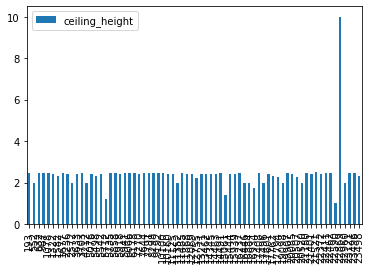

In [12]:
# Изменить высоту потолка для данны, где она указана > 10 м
data.loc[data["ceiling_height"] > 10, "ceiling_height"] = data["ceiling_height"]/10
# Сколько квартир не соответствую условию 2.5 м <= ceiling_height < 10 м
print("Количество квартир не соответствующих условию 2.5 м <= ceiling_height < 10 м:", len(data[(data["ceiling_height"] >= 10) | (data["ceiling_height"] < 2.5)]["ceiling_height"]))
# Проверка значений, которые вошли в срез
data.query("ceiling_height >= 10 or ceiling_height < 2.5").plot(y = "ceiling_height", kind = "bar")
data.info()

In [13]:
# У некоторых квартир высота примерно равна 2.5 м.
print("Количество квартир соответсвтующих условию 2.4 м <= ceiling_height < 2.5 м:", len(data[(data["ceiling_height"] >= 2.4) & (data["ceiling_height"] < 2.5)]["ceiling_height"]))
# Можно принять это за ошибку измерений и сделать менее жесткий допуск в 2.4 м
# Получение обновленной таблицы
data = data[(data["ceiling_height"] < 10) & (data["ceiling_height"] >= 2.4)]
data["ceiling_height"].describe()

Количество квартир соответсвтующих условию 2.4 м <= ceiling_height < 2.5 м: 48


count    21113.000000
mean         2.698801
std          0.231787
min          2.400000
25%          2.600000
50%          2.650000
75%          2.700000
max          8.300000
Name: ceiling_height, dtype: float64

**Выводы:**
- Аномально высокие значения либо были перевычислены, либо исключены (исключен 1 объект)
- Квартиры с аномально низкими потолками были исключены (исключены 26 объектов)


#### Проверка согласованности площади

In [14]:
# Поиск квартир с несогласованной площадью (кухня + жилая зона должны быть меньше общей площади)
data[data["total_area"] <= (data["kitchen_area"] + data["living_area"])][["total_area","kitchen_area","living_area"]]

,total_area,kitchen_area,living_area
184,30.20,6.20,26.10
220,37.00,9.00,28.00
545,23.80,5.00,20.00
551,31.59,9.28,30.55
601,53.70,7.00,48.30
...,...,...,...
22693,82.40,25.00,57.40
22963,102.00,24.00,78.00
23202,67.92,13.04,63.00
23297,48.20,6.00,42.20


In [15]:
# Удаление таких квартир из датасета
data = data[data["total_area"] > (data["kitchen_area"] + data["living_area"])]


#### Проверка площадей кухонь

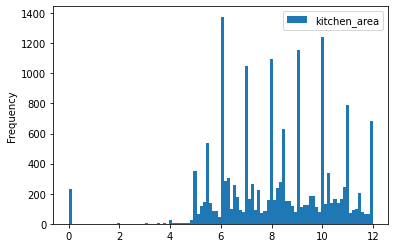

In [16]:
# Проверка слишком маленьких площадей кухонь. 75% площади кухонь до 12 м^2; этот диапазон исследуем подробнее
data.plot(y="kitchen_area", kind="hist", bins=100, range=(0,12))
plt.show()

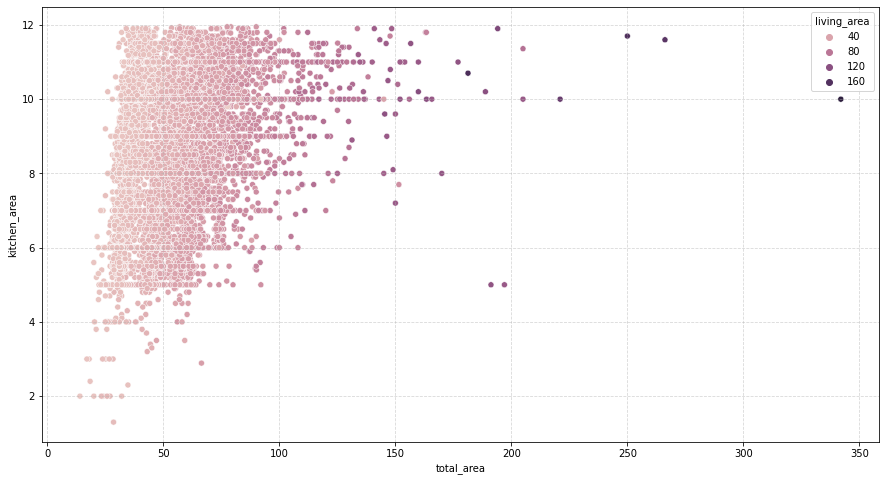

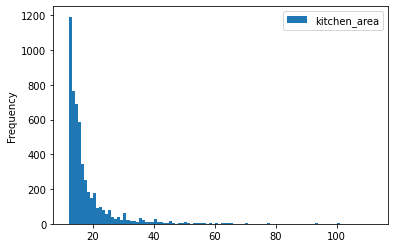

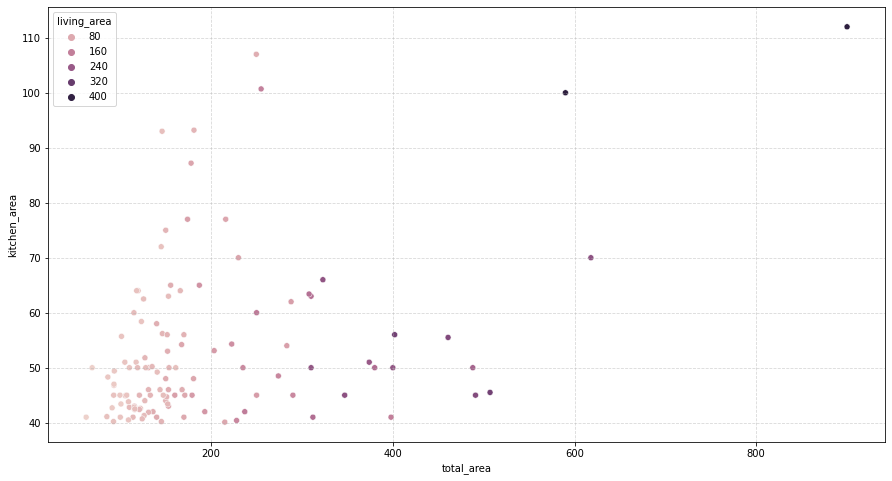

In [17]:
# Первый пик наблюдается на 4 м^2, возьмем эти данные как границу

# Построим зависимость площади кухни от площади квартиры, 
#цвет выбирается в зависимости от площади жилой зоны для наглядности
sns.scatterplot(
    data=data.loc[(data["kitchen_area"] < 12) & (data["kitchen_area"] != 0)], 
    x="total_area", 
    y="kitchen_area", 
    hue= "living_area")
plt.gcf().set_size_inches(15, 8)
plt.grid(linestyle='--', alpha=0.5)
plt.show()

# Проверим теперь остальные 25% квартир, где площади от 12 до 112 м^2
data.plot(y="kitchen_area", kind="hist", bins=100, range=(12,112))
plt.show()
# Закономерно, что количество квартир с большими по площади кухнями меньше. 
#Чтобы убедиться, что нет аномально больших площадей кухонь, не соответсвующих действительности,
# выведем построим график для всех квартир, где площадь кухни > 40 м^2
sns.scatterplot(
    data=data.loc[data["kitchen_area"] > 40], 
    x="total_area", 
    y="kitchen_area", 
    hue= "living_area")
plt.gcf().set_size_inches(15, 8)
plt.grid(linestyle='--', alpha=0.5)
plt.show()

# Площади квартир и кухонь согласованы

#### Провека площадей жилых зон

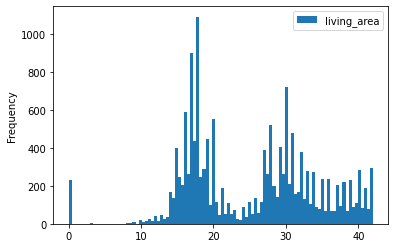

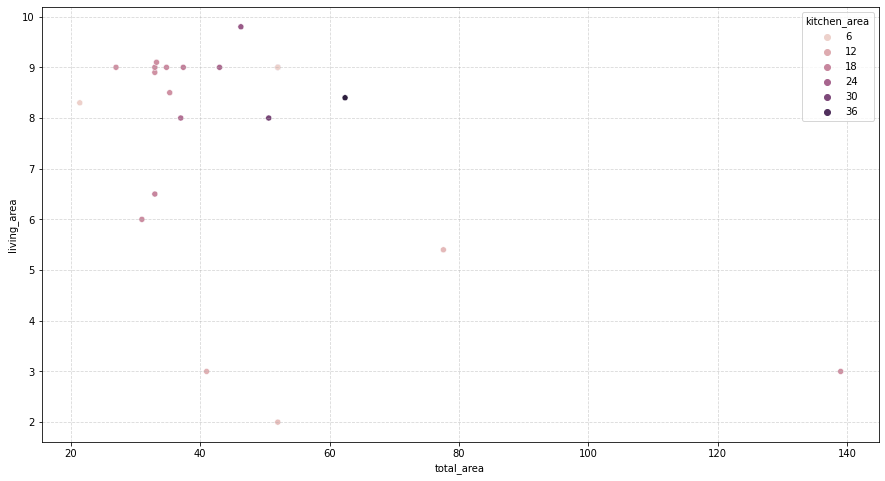

In [18]:
# Проверка слишком маленьких площадей жилых зон. 75% площади кухонь до 42 м^2; этот диапазон исследуем подробнее
data.plot(y="living_area", kind="hist", bins=100, range=(0,42))
plt.show()
# Первый пик наблюдается около 10 м^2, возьмем эти данные как границу
# и изучем квартиры с меньшей площадью
sns.scatterplot(
    data=data.loc[(data["living_area"] < 10) & data["living_area"] != 0], 
    x="total_area", 
    y="living_area", 
    hue= "kitchen_area")
plt.gcf().set_size_inches(15, 8)
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [19]:
# Есть 4 квартиры с жилой зоной меньше 6 м^2, выведем информацию о них
data[(data["living_area"] < 6) & (data["living_area"] != 0)][
    ["total_area",
     "living_area",
     "kitchen_area",
     "open_plan",
     "studio",
     "is_apartment"]]

,total_area,living_area,kitchen_area,open_plan,studio,is_apartment
3242,41.0,3.0,11.0,False,False,False
13915,52.0,2.0,9.0,False,False,False
21943,77.6,5.4,9.8,False,False,False
23574,139.0,3.0,16.0,False,False,False


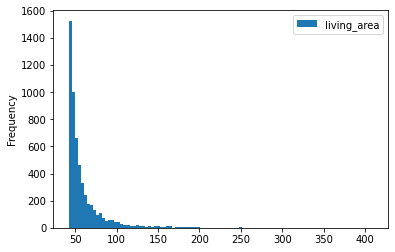

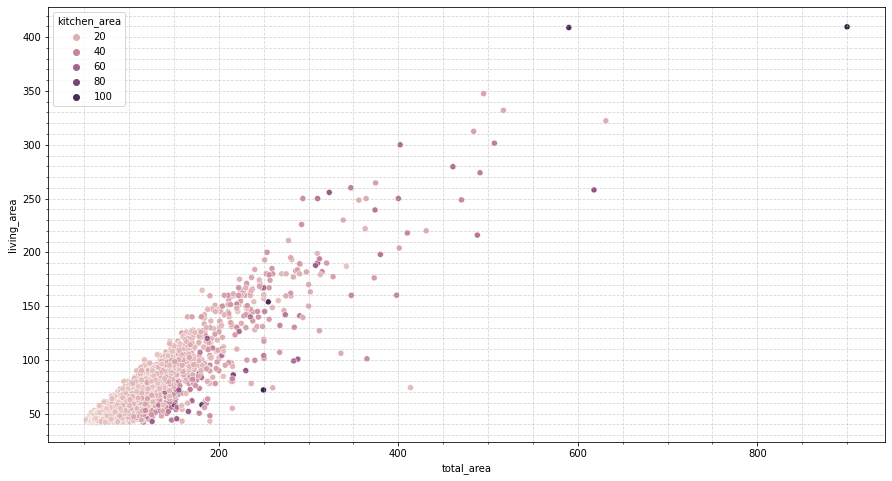

In [20]:
# Для 3 объектов можно предположить, что площадь поставлена неккоректо и ее следует умножить на 10.
# У одного объекта подобное умножение приведет к несогласованности с общей площадью, поэтому его удаляем.
data.loc[
    (data["living_area"] < 6) & ((data["studio"] == False) | (data["is_apartment"] == False)  | (data["open_plan"] == False))
    & (data["total_area"] > (data["kitchen_area"]+data["living_area"]*10)),
    "living_area"] = data["living_area"]*10
data = data[
    (data["living_area"] > 6)|
    ((data["studio"] == True) | (data["open_plan"] == True) | (data["is_apartment"] == True))]

# Построим зависимость площади жилой зоны от площади квартиры для остальных 25% квартир, 
#цвет выбирается в зависимости от площади кухни зоны для наглядности
data.plot(y="living_area", kind="hist", bins=100, range=(42,409.7))
plt.show()

sns.scatterplot(
    data=data.loc[data["living_area"] > 42], 
    x="total_area", 
    y="living_area", 
    hue= "kitchen_area")
plt.gcf().set_size_inches(15, 8)
plt.minorticks_on()
plt.grid(which="both", linestyle='--', alpha=0.5)
plt.show()

**Выводы:**
- Разброс значений объясним различиями в площадях квартиры, явных выбросов, которые можно однозначно исключить не наблюдается.  
- Есть квартиры с малой площадью кухни (меньше 4 м^2), но они вполне могут существовать в старом фонде, так что исключать их нельзя.
- Была удалена одна квартира со слишком малой площадью жилой зоны.
- Преобразована площадь жилой зоны для трех квартир.

#### Проверка цен

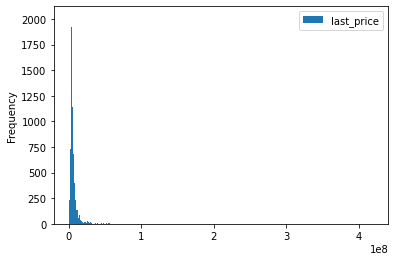

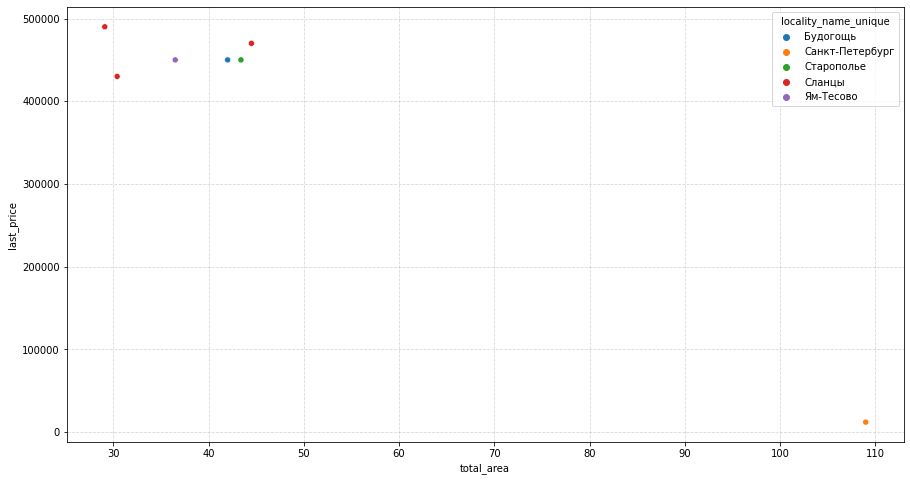

In [21]:
data.plot(y="last_price", kind="hist", bins=1000)
plt.show()
# Проверка слишком малых по стоимости квартир
sns.scatterplot(
    data=data.loc[data["last_price"] < 500000], 
    x="total_area", 
    y="last_price", 
    hue="locality_name_unique")
plt.gcf().set_size_inches(15, 8)
plt.grid(linestyle='--', alpha=0.5)
plt.show()

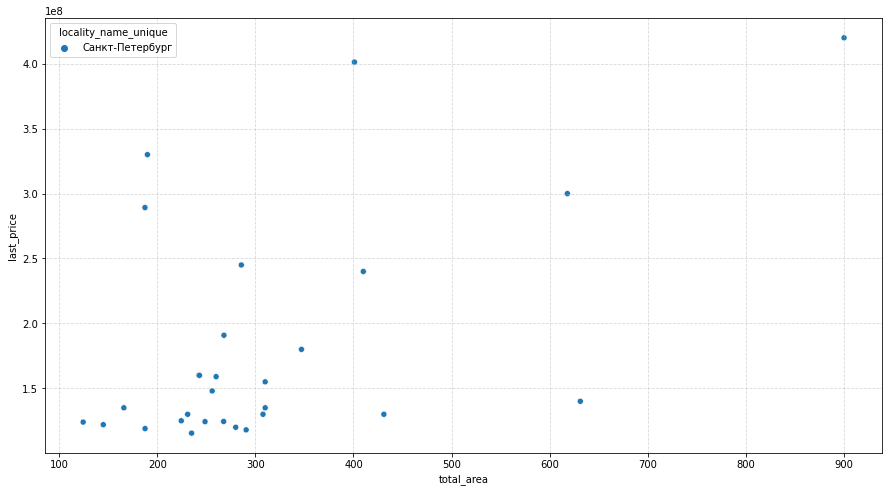

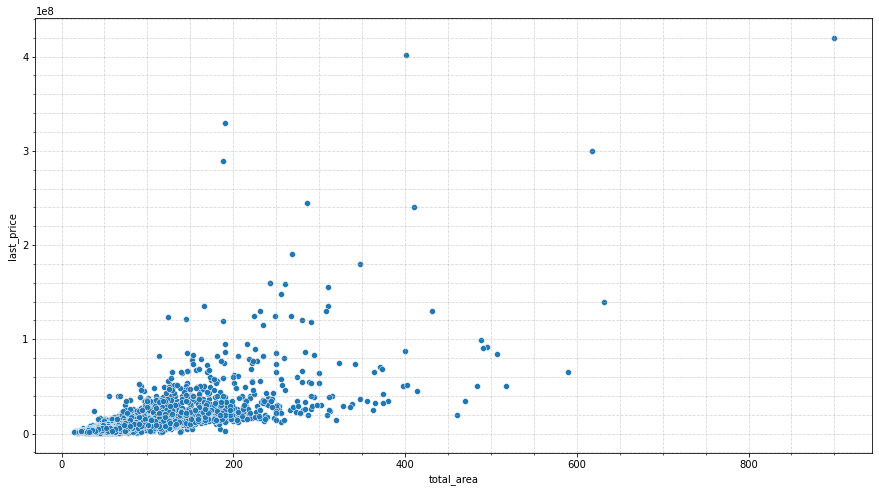

In [22]:
# Удаление квартиры с минимальной стоимостью, 
#т.к. квартира стоит слишком мало для площади около 110 м^2
min_price = data["last_price"].min()
data = data[data["last_price"] != min_price]
# Проверка квартир с очень высокой стоимостью
sns.scatterplot(
    data=data.loc[data["last_price"] > 100000000], 
    x="total_area", 
    y="last_price", 
    hue="locality_name_unique")
plt.gcf().set_size_inches(15, 8)
plt.grid(linestyle='--', alpha=0.5)
plt.show()
# Диаграмма рассеивания для всех квартир
sns.scatterplot(
    data=data, 
    x="total_area", 
    y="last_price")
plt.gcf().set_size_inches(15, 8)
plt.minorticks_on()
plt.grid(which="both", linestyle='--', alpha=0.5)
plt.show()

**Вывод**  
Цена согласована с площадью. Самые большие по площади квартиры представлены в Санкт-Петербурге. Единственный выброс с минимальной стоимостью был удален из датасета.

#### Проверка количества комнат

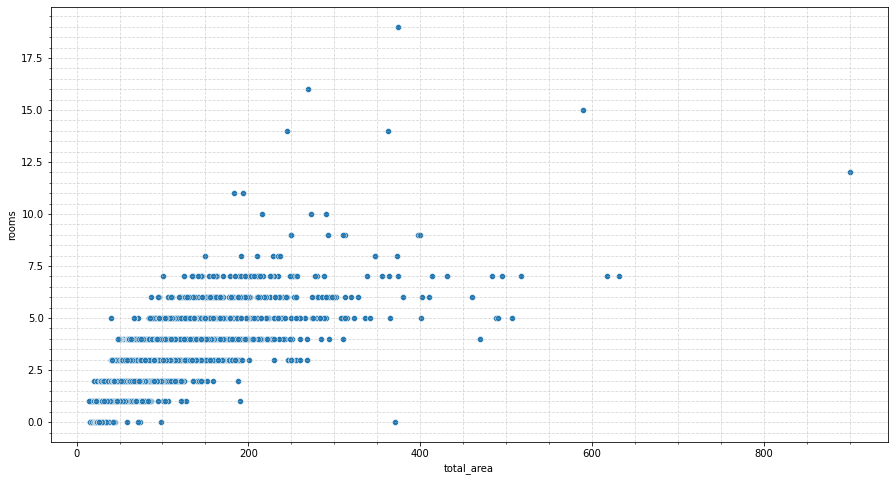

In [23]:
# Проверка на выбросы в количестве комнат
sns.scatterplot(
    data=data, 
    x="total_area", 
    y="rooms")
plt.gcf().set_size_inches(15, 8)
plt.minorticks_on()
plt.grid(which="both", linestyle='--', alpha=0.5)
plt.show()

**Вывод:**  
Количество комнат соответствует площади, нигде однозначно нельзя отбросить данные. Выбросов не обнаружено.

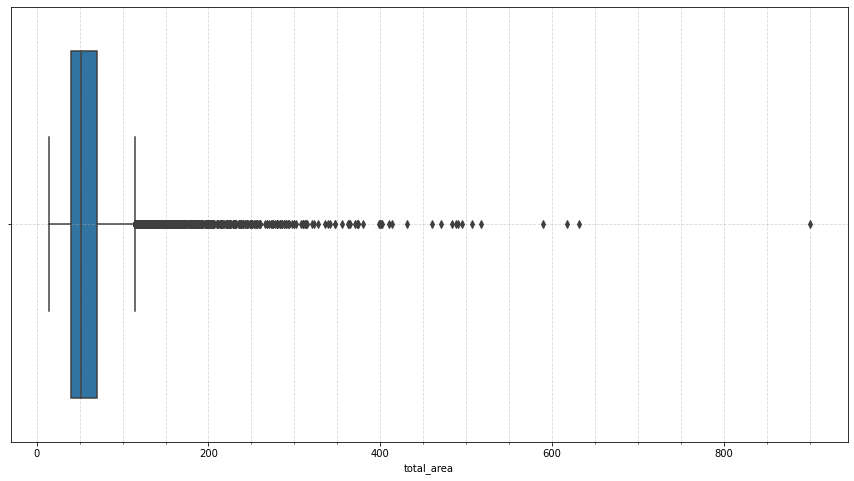

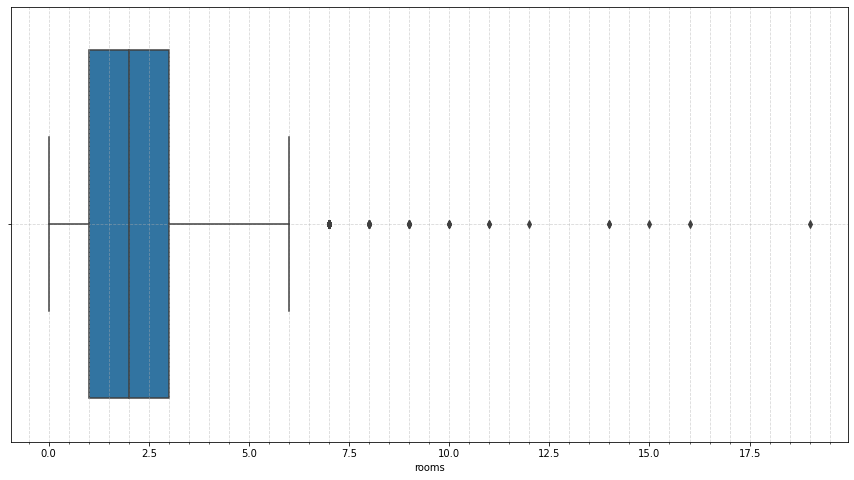

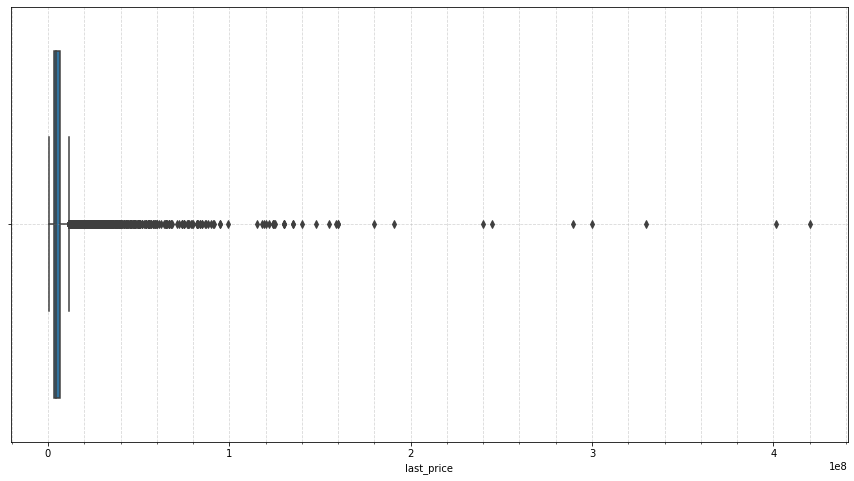

In [24]:
# Датафрейм до удаления выбросов:
old_data = data.copy(deep=True) # сохранение предыдущего датафрейма
len_0 = old_data.shape[0]
boxplot_info = ["total_area","rooms","last_price"]
for x in boxplot_info:
    sns.boxplot(
    x=data[x])
    plt.gcf().set_size_inches(15, 8)
    plt.minorticks_on()
    plt.grid(which="both", linestyle='--', alpha=0.5)    
    plt.show()


Согласно графикам выбросами будут считаться следующие значения:
1. Общая площадь больше 125 квадратов.
2. Количество квартир больше 6.
3. Цена больше 12 млн.  

Уберем объекты, которые являются выбросами этим условиям. 

In [25]:
data = data[(data["total_area"] <= 125) & (data["rooms"] < 7) & (data["last_price"] < 12000000)]
len_1 = data.shape[0]
print("Процент сохраненных значений:", round(len_1/len_0*100))


Процент сохраненных значений: 91


## Посчитайте и добавьте в таблицу новые столбцы

In [26]:
# Определение цены кв.м; 
# дня недели, месяца, года публикации объявления; 
# перевод расстояния до центра в км
data["square_meter_price"] = (data["last_price"]/data["total_area"]).round(1)
data["pub_weekday"] = data["first_day_exposition"].dt.weekday
data["pub_month"] = data["first_day_exposition"].dt.month
data["pub_year"] = data["first_day_exposition"].dt.year
data["cityCentres_km"] = (data["cityCenters_nearest"]/1000).round(0)


In [27]:
# Определение типа этажа квартиры
def floor_info(row):    
    if row["floor"] == 1:
        return "первый"
    elif row["floor"] == row["floors_total"]:
        return "последний"
    else:
        return "другой"

data["floor_type"] = data.apply(floor_info,axis=1)

data.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,locality_name_unique,square_meter_price,pub_weekday,pub_month,pub_year,cityCentres_km,floor_type
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,Шушары,82920.8,1,12,2018,19.0,первый
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,Санкт-Петербург,92785.7,3,8,2015,14.0,другой
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,Санкт-Петербург,100000.0,1,6,2018,8.0,другой
5,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,False,False,False,9.1,0,городской посёлок Янино-1,NaN,NaN,0,NaN,0,NaN,55.0,Янино-1,95065.8,0,9,2018,NaN,другой
6,6,3700000,37.3,2017-11-02,1,2.65,26,10.6,6,False,False,False,14.4,1,посёлок Парголово,52996.0,19143.0,0,NaN,0,NaN,155.0,Парголово,99195.7,3,11,2017,19.0,другой


## Проведите исследовательский анализ данных

### Изучение параметров объектов

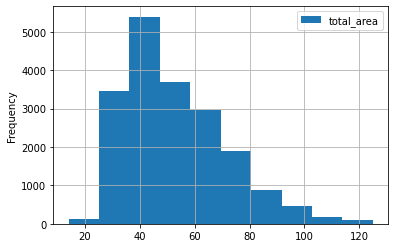

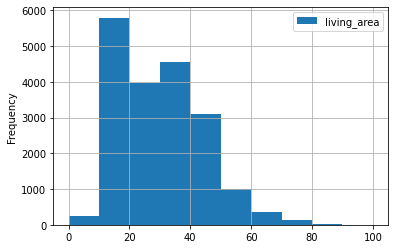

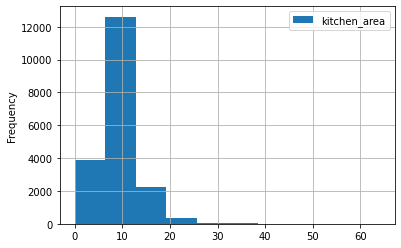

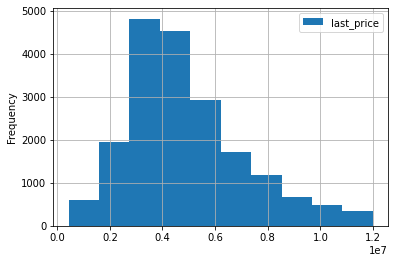

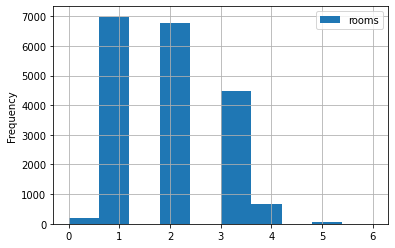

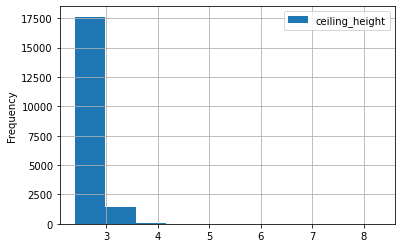

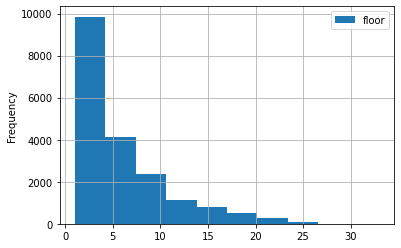

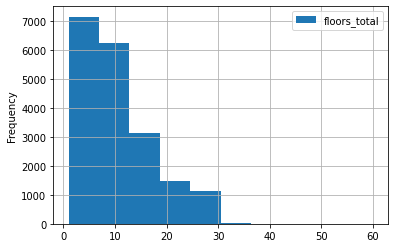

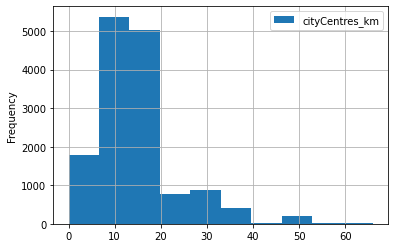

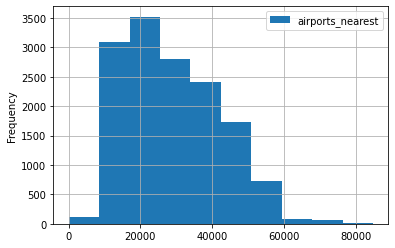

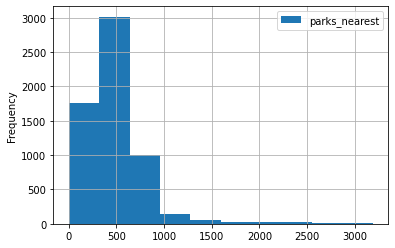

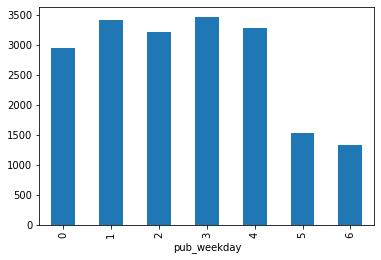

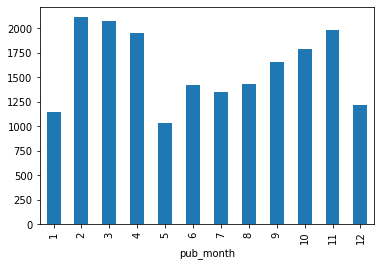

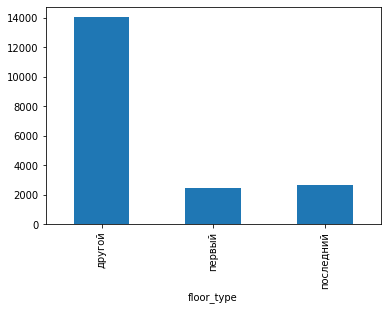

In [28]:
hist_info = ["total_area",
             "living_area",
             "kitchen_area",
             "last_price",
             "rooms",
             "ceiling_height",
             "floor",
             "floors_total",
             "cityCentres_km", 
             "airports_nearest",
             "parks_nearest"]
#
for x in hist_info:
    data.plot(y=x, kind="hist", grid=True)
    plt.show()
    

    bar_info = ["pub_weekday","pub_month","floor_type"]

for x in bar_info:
    data.groupby(by=x).agg("count")["total_images"].plot.bar()
    plt.show()


**Выводы:**
1. Подавляющее большинство объектов в наборе имеют площадь до 100 квадратных метров.
2. Площади жилых зон и кухонь распределены согласно площадям объектов. Большинство жилых площадей до 50 квадратных метров, кухонь - до 20 квадратных метров.
3. У большинства объектов до 4 комнат.
4. Большинство объектов имеют потолки до 3 м, но также присутствуют потолки до 3.5 м (примерно 20% объектов). Малое количество объектов имеют большую высоту потолка.
5. Количество объектов снижается с увеличением этажа.
6. Большинство зданий также имеют малую этажность. 90% объектов располагаются в зданиях до 20 этажей.
7. Примерно 80% объектов находятся на удалении до 20 км от центра.
8. Малое количество объектов располагается на удалении 10 км от аэропорта, большинство от 10 км до 60 км.
9. Большинство объектов имеет в пешей доступности парк (примерно 500 м).
10. Чаще объявления публикуют во вторник и четверг, реже - в выходные.
11. Меньше всего объявления публикуют в январе, мае и декабре; больше - феврале, марте и ноябре.
12. Квартир на первом этаже меньше, потом идут квартиры на последнем и больше всего на других этажах (примерно в 6 раз).

### Изучение скорости продажи квартир

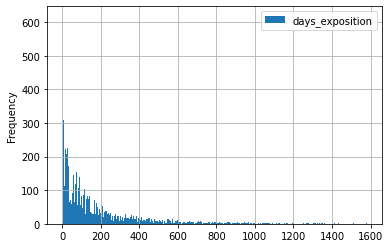

count    16773.000000
mean       177.051631
std        213.538398
min          1.000000
25%         43.000000
50%         97.000000
75%        226.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [29]:
data.plot(y="days_exposition",kind="hist",bins=1000,grid=True)
plt.show()
data["days_exposition"].describe()

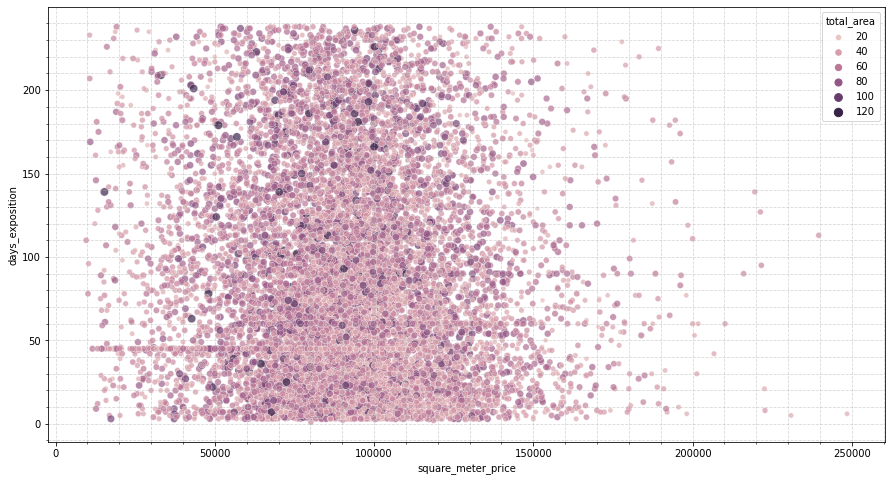

In [30]:
# Подробное изучение объектов, которые продаются в течение 238 дней
sns.scatterplot(
    data=data.loc[data["days_exposition"] <= 238], 
    x="square_meter_price", 
    y="days_exposition", 
    hue="total_area",
    size="total_area",
    s=5,
    alpha=0.7)
plt.gcf().set_size_inches(15, 8)
plt.minorticks_on()
plt.grid(which="both", linestyle='--', alpha=0.5)
plt.show()

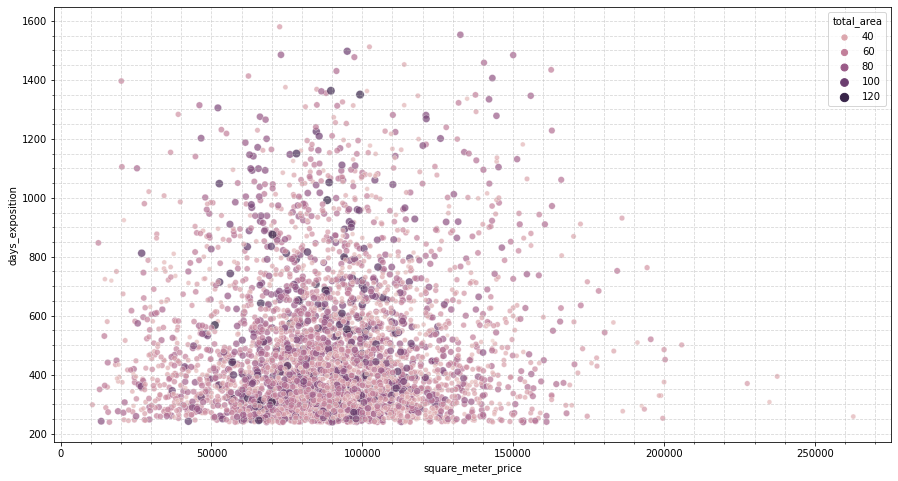

In [31]:
# Подробное изучение объектов, которые дольше всего продаются
sns.scatterplot(
    data=data.loc[data["days_exposition"] > 238], 
    x="square_meter_price", 
    y="days_exposition", 
    hue="total_area",
    size="total_area",
    s=12,
    alpha=0.7)
plt.gcf().set_size_inches(15, 8)
plt.minorticks_on()
plt.grid(which="both", linestyle='--', alpha=0.5)
plt.show()

Text(0.5, 1.0, 'Корреляция времени продажи')

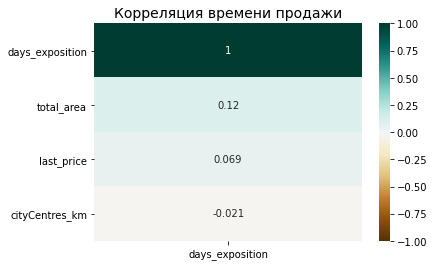

In [32]:
# Корреляция Пирсона
sns.heatmap(
    data
    [["last_price",
     "total_area", 
     "days_exposition",
      "cityCentres_km"
     ]].corr()[["days_exposition"]].sort_values(by="days_exposition", ascending=False),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap='BrBG').set_title(
    "Корреляция времени продажи",  fontdict={'fontsize':14})

**Вывод:**   
Медианное значение времени продажи - 101 день, 50% объектов продается за это время. До 600 дней продается большинство объектов. 
Как видно из графиков, больше времени занимает продажа объектов с большей площадью. Для объектов с площадью менее 100 квадратов можно сказать, что время продажи практически не зависит от стоимость квадратного метра. Это же демонстируют коэффициенты корреляции.

### Изучение факторов, влияющих на стоимость

Для недвижимости всех типов посчитаем зависимость цены от общей площади,типа этажа, даты размещения объявления.  
Для нахождения зависимостей цены от площади жилой зоны, кухни, количества комнат недвижимость разделим на 4 группы: апартаменты, студии, свободная планировка и остальная недвидимость. 

In [33]:
studios = data[data["studio"]==True][
    ["last_price",
     "total_area", 
     "floor_type", 
     "first_day_exposition","pub_weekday",
     "pub_month",
     "pub_year",
     "cityCentres_km"]]
apartments = data[data["is_apartment"]==True][
    ["last_price",
     "total_area", 
     "floor_type", 
     "first_day_exposition",
     "living_area",
     "kitchen_area",
     "rooms","pub_weekday", 
     "pub_month",
     "pub_year", 
     "cityCentres_km"]]
open_plans = data[data["is_apartment"]==True][
    ["last_price",
     "total_area", 
     "floor_type", 
     "first_day_exposition","pub_weekday",
     "pub_month",
     "pub_year",
     "cityCentres_km"]]
others = data[(~(data["studio"])) & (~(data["is_apartment"])) & (~(data["is_apartment"]))][
    ["last_price",
     "total_area", 
     "floor_type", 
     "first_day_exposition",
     "living_area",
     "kitchen_area",
     "rooms","pub_weekday", 
     "pub_month",
     "pub_year", 
     "cityCentres_km"]]

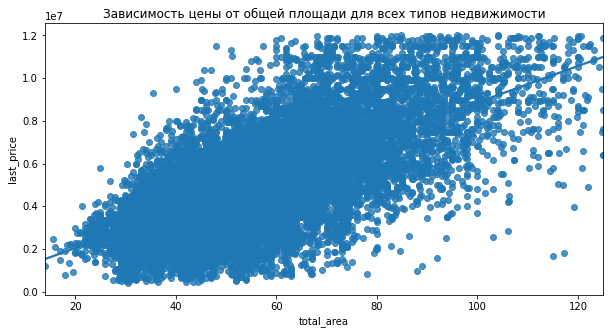

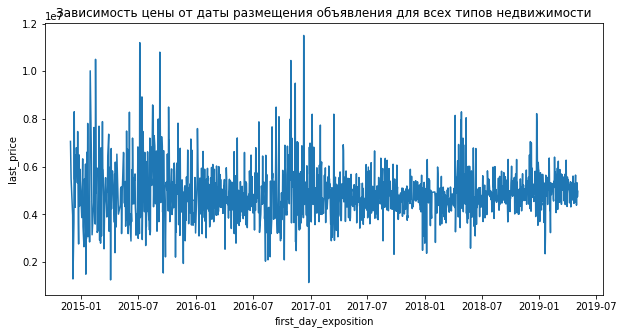

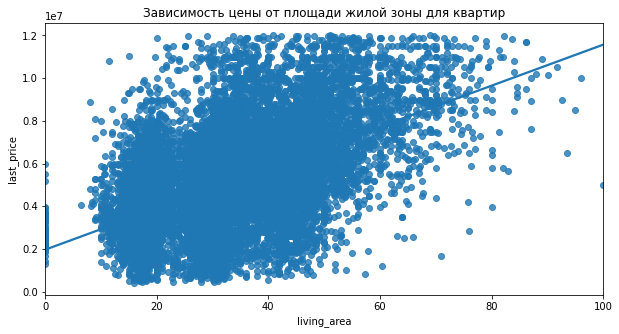

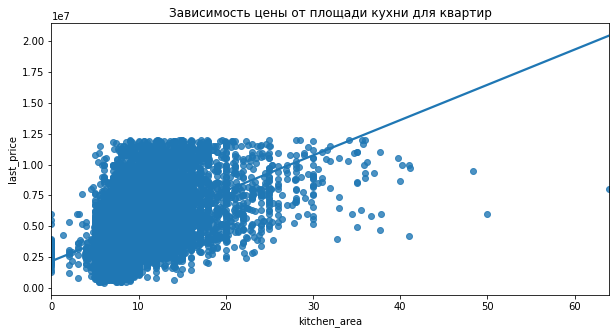

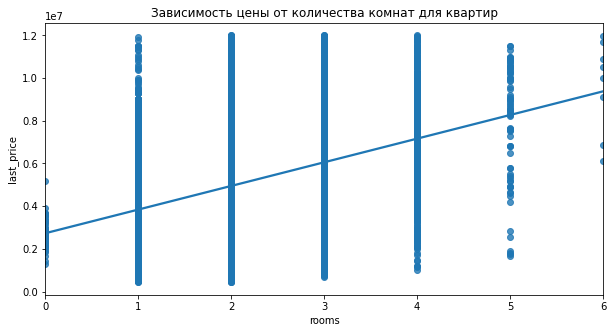

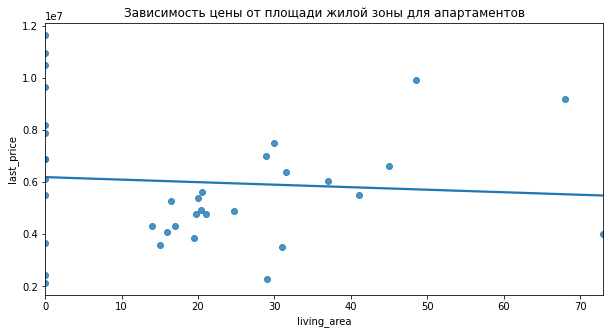

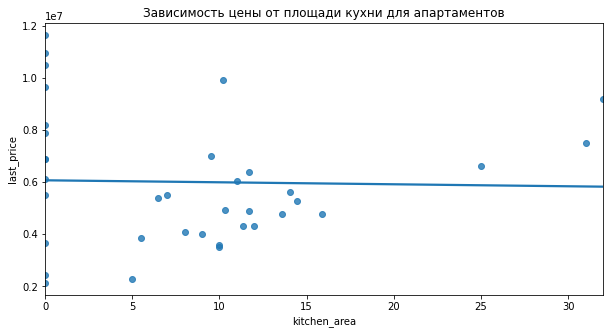

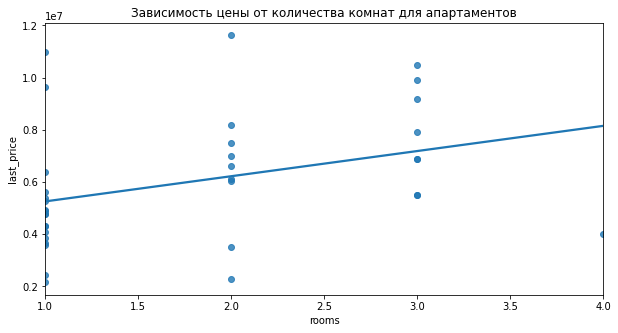

In [34]:
sns.regplot(data=data, x="total_area", y="last_price", ci=None).axes.set_title(
    "Зависимость цены от общей площади для всех типов недвижимости")
plt.gcf().set_size_inches(10, 5)
plt.show()
sns.lineplot(data=data, x="first_day_exposition", y="last_price", ci=None).axes.set_title(
    "Зависимость цены от даты размещения объявления для всех типов недвижимости")
plt.gcf().set_size_inches(10, 5)
plt.show()

sns.regplot(data=others,x="living_area", y="last_price", ci=None).axes.set_title(
    "Зависимость цены от площади жилой зоны для квартир")
plt.gcf().set_size_inches(10, 5)
plt.show()
sns.regplot(data=others,x="kitchen_area", y="last_price", ci=None).axes.set_title(
    "Зависимость цены от площади кухни для квартир")
plt.gcf().set_size_inches(10, 5)
plt.show()
sns.regplot(data=others, x="rooms", y="last_price", ci=None).axes.set_title(
    "Зависимость цены от количества комнат для квартир")
plt.gcf().set_size_inches(10, 5)
plt.show()

sns.regplot(data=apartments,x="living_area", y="last_price", ci=None).axes.set_title(
    "Зависимость цены от площади жилой зоны для апартаментов")
plt.gcf().set_size_inches(10, 5)
plt.show()
sns.regplot(data=apartments,x="kitchen_area", y="last_price", ci=None).axes.set_title(
    "Зависимость цены от площади кухни для апартаментов")
plt.gcf().set_size_inches(10, 5)
plt.show()
sns.regplot(data=apartments, x="rooms", y="last_price", ci=None).axes.set_title(
    "Зависимость цены от количества комнат для апартаментов")
plt.gcf().set_size_inches(10, 5)
plt.show()



По отдельным графикам сложно сказать насколько сильна зависимость цены от площадей и количества комнат, но очевидно, что она есть. 

Площадь, количество комнат, год и расстояние от центра являются числовыми характеристиками, так что зависимость можно оценить с помощью корреляции Пирсона.

Text(0.5, 1.0, 'Корреляция цены для всех типов недвижимости')

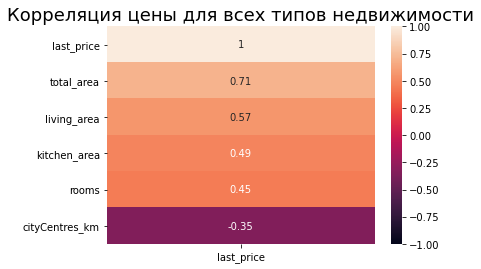

In [35]:
sns.heatmap(
    data[["last_price",
     "total_area", 
     "floor_type", 
     "first_day_exposition",
     "living_area",
     "kitchen_area",
     "rooms", 
     "cityCentres_km"]].corr()[["last_price"]].sort_values(by="last_price", ascending=False),
    vmin=-1,
    vmax=1,
    annot=True).set_title(
    "Корреляция цены для всех типов недвижимости",  fontdict={'fontsize':18})

Text(0.5, 1.0, 'Корреляция цены квартиры')

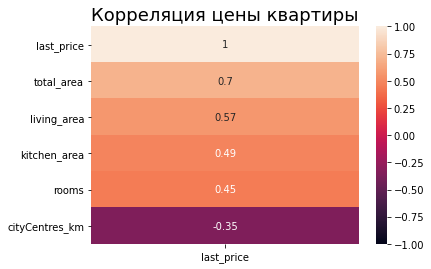

In [36]:
sns.heatmap(
    others[["last_price",
     "total_area", 
     "floor_type", 
     "first_day_exposition",
     "living_area",
     "kitchen_area",
     "rooms",
     "cityCentres_km"]].corr()[["last_price"]].sort_values(by="last_price", ascending=False),
    vmin=-1,
    vmax=1,
    annot=True).set_title(
    "Корреляция цены квартиры",  fontdict={'fontsize':18})


Text(0.5, 1.0, 'Корреляция цены апартаментов')

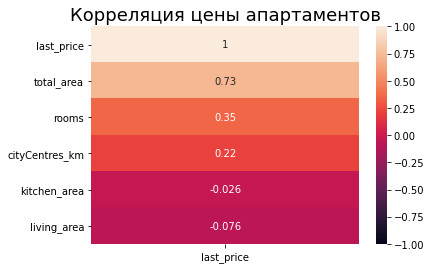

In [37]:
sns.heatmap(
    apartments
    [["last_price",
     "total_area", 
     "floor_type", 
     "first_day_exposition",
     "living_area",
     "kitchen_area",
     "rooms", 
     "cityCentres_km"]].corr()[["last_price"]].sort_values(by="last_price", ascending=False),
    vmin=-1,
    vmax=1,
    annot=True).set_title(
    "Корреляция цены апартаментов",  fontdict={'fontsize':18})

Text(0.5, 1.0, 'Корреляция цены студии')

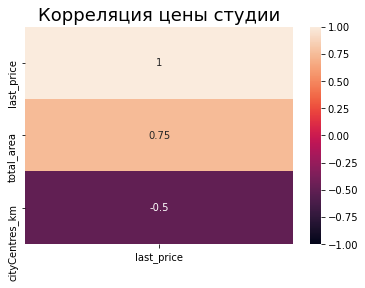

In [38]:
sns.heatmap(
    studios
    [["last_price",
     "total_area", 
     "floor_type", 
     "first_day_exposition", 
     "cityCentres_km"]].corr()[["last_price"]].sort_values(by="last_price", ascending=False),
    vmin=-1,
    vmax=1,
    annot=True).set_title(
    "Корреляция цены студии",  fontdict={'fontsize':18})

Text(0.5, 1.0, 'Корреляция цены квартиры со свободной планировкой')

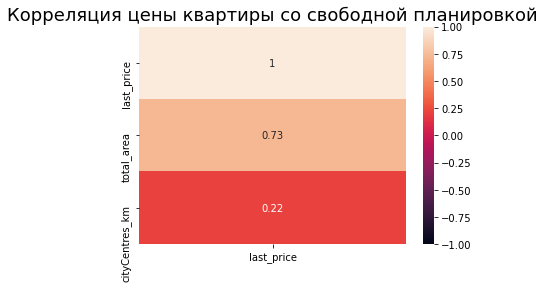

In [39]:
sns.heatmap(
    open_plans
    [["last_price",
     "total_area", 
     "floor_type", 
     "first_day_exposition", 
     "cityCentres_km"]].corr()[["last_price"]].sort_values(by="last_price", ascending=False),
    vmin=-1,
    vmax=1,
    annot=True).set_title(
    "Корреляция цены квартиры со свободной планировкой",  fontdict={'fontsize':18})

**Вывод:**  
Для всех типов недвижимости цена наиболее зависима от площади и удаления от центра. Однако в квартирах со свободной планировкой и апартаментах наблюдается учеличение цены с удалением от центра, но это может быть не показательно в связи с малым количеством объектов в выборке.  

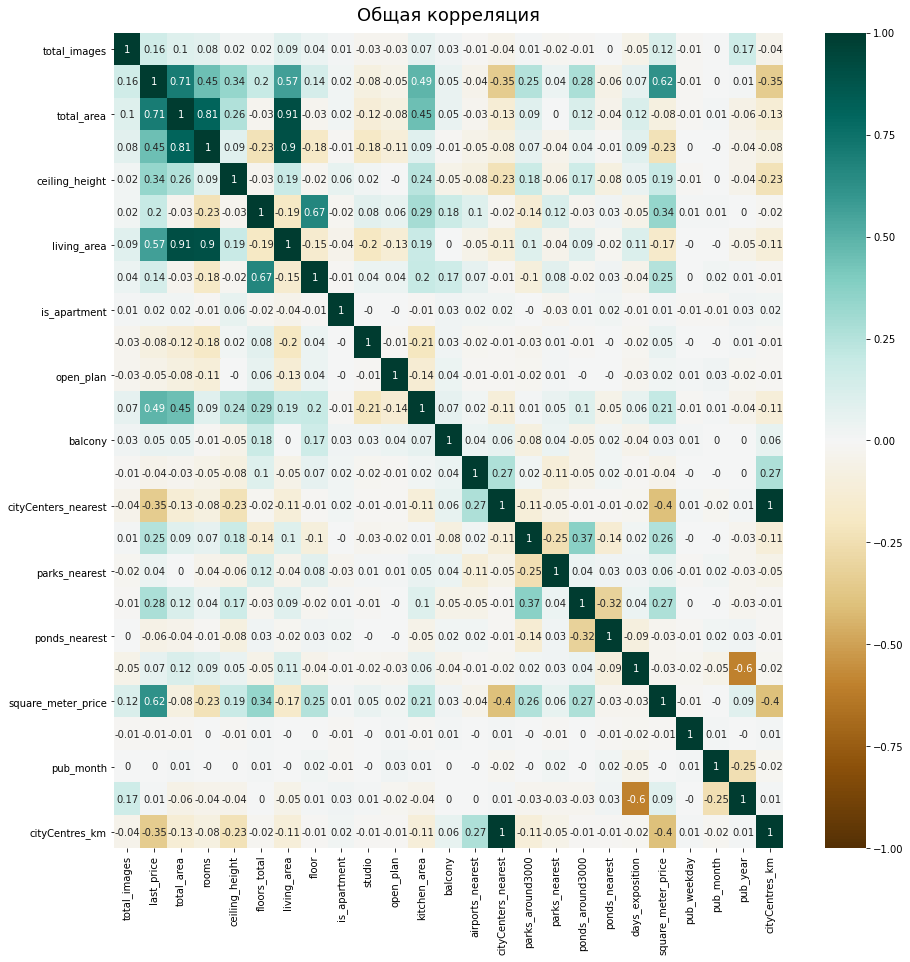

In [40]:
sns.heatmap(
    data.corr().round(2), 
    vmin=-1, 
    vmax=1, 
    annot=True, 
    cmap='BrBG').set_title('Общая корреляция', fontdict={'fontsize':18}, pad=12);
plt.gcf().set_size_inches(15, 15)
plt.show()

Исключение недвижимости с самой высокой ценой пактически не поменяло ситуацию. Предполагается, что цена недвижимости растет из года в год. Проверим это с помощью столбчатой диаграммы, выбрав медианную цену квадратного метра, может большие по площади квартиры перетягивают цену на себя.

Text(0.5, 1.0, 'Средняя цена за квартиру')

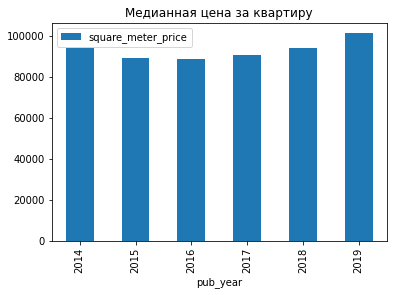

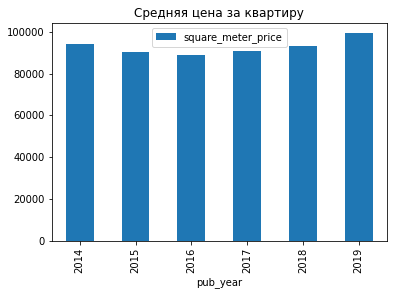

In [41]:
pd.pivot_table(data=data, index="pub_year", values="square_meter_price",aggfunc="median").plot.bar().set_title(
    "Медианная цена за квартиру")
pd.pivot_table(data=data, index="pub_year", values="square_meter_price",aggfunc="mean").plot.bar().set_title(
    "Средняя цена за квартиру")

Цена квадратного метра действительно растет в 2016-2019 годах. Однако пик цены все равно находится в 2014 году. 

Тип этажа (первый, последний, другой), месяц и день недели это категорийные параметр, поэтому найдем медианную цену в засимости от выбранного параметра.

<AxesSubplot:xlabel='floor_type'>

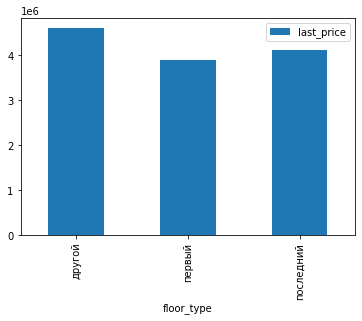

In [42]:
pd.pivot_table(data=data, index="floor_type", values="last_price",aggfunc="median").plot.bar()

Text(0.5, 1.0, 'Средняя цена за квартиру')

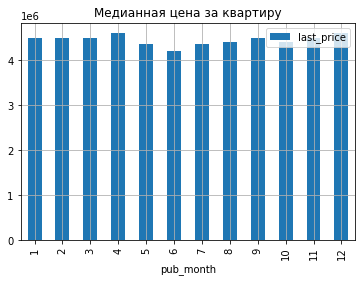

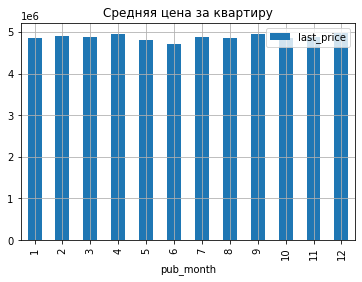

In [43]:
pd.pivot_table(
    data=data, index="pub_month", values="last_price",aggfunc="median").plot.bar(grid=True).set_title(
    "Медианная цена за квартиру")
pd.pivot_table(
    data=data, index="pub_month", values="last_price",aggfunc="mean").plot.bar(grid=True).set_title(
    "Средняя цена за квартиру")

Text(0.5, 1.0, 'Средняя цена за квартиру')

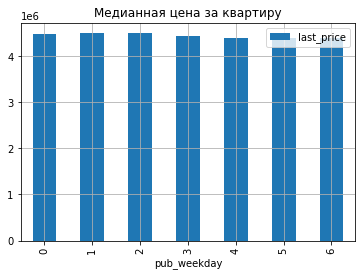

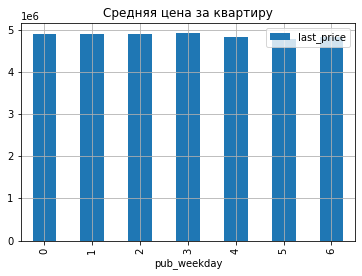

In [44]:
pd.pivot_table(
    data=data, index="pub_weekday", values="last_price",aggfunc="median").plot.bar(grid=True).set_title(
    "Медианная цена за квартиру")
pd.pivot_table(
    data=data, index="pub_weekday", values="last_price",aggfunc="mean").plot.bar(grid=True).set_title(
    "Средняя цена за квартиру")

**Вывод:**  
Меньшую цену имеет первый этаж, далее последний и наиболее высокую другие этажи. Это можно объяснить неравномерностью выборок, т.к. в "другой" входит однозначно больше значений, тем в остальные. Однако за первый этаж цена всегда меньше, чем за остальные. В новостройках сейчас последний этаж самый дорогой, на вторичном рынке наоборт люди предпочитают чаще другие этажи. Но данная выборка не поднимает такие вопросы.  
В апреле, сентябре и декабре цены максимальны. Наибольшая просадка в цене наблюдается в июне.  
Зависимости цены от дня публикации не наблюдается, они все примерно на одном уровне.

### Населенные пункты с самой низкой и самой высокой ценой квадратного метра

In [45]:
popular_location = (
    data.groupby(by="locality_name_unique")["square_meter_price"]
    .agg(["mean","count"])
    .sort_values(by="count",ascending=False)
)
popular_location.columns = ["Средняя цена квадратного метра","Количество объявлений"]
popular_location.head(10)



,Средняя цена квадратного метра,Количество объявлений
locality_name_unique,,
Санкт-Петербург,105336.012508,12360
Мурино,86280.471784,482
Кудрово,95198.274873,394
Шушары,78678.711421,394
Всеволожск,67371.938418,354
Колпино,75046.248276,319
Пушкин,100573.313072,306
Парголово,90610.156164,292
Гатчина,68414.243972,282


**Самая высокая стоимость квадратного метра в Санкт-Петербурге, самая низкая во Всеволожске.**

### Зависимость цены от расстояния до центра

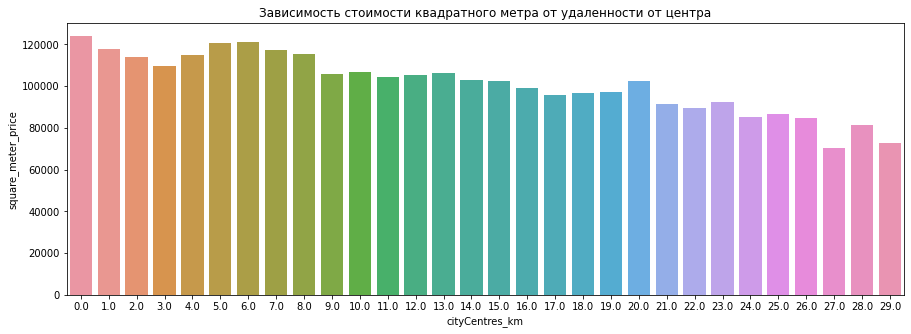

In [46]:
sns.barplot(
    data=data[data["locality_name_unique"] == "Санкт-Петербург"],
    x="cityCentres_km",
    y="square_meter_price",
    ci=None).set_title("Зависимость стоимости квадратного метра от удаленности от центра")
plt.gcf().set_size_inches(15, 5)

Как и ожидалось, цена квадратного метра больше для центра. Начиная с 8 км видно падение цены.

## Общий вывод

В работе был произведен анализ датасета от Яндекс Недвижимости. 

Всего датасет включал в себя объекты, о которых известны следующие параметры:
- расстояние до ближайшего аэропорта в метрах (м)
- число балконов
- высота потолков (м)
- расстояние до центра города (м)
- сколько дней было размещено объявление (от публикации до снятия)
- дата публикации
- этаж
- всего этажей в доме
- апартаменты ли это
- площадь кухни в квадратных метрах (м²)
- цена на момент снятия с публикации
- жилая площадь в квадратных метрах (м²)
- название населённого пункта
- свободная ли это планировка
- число парков в радиусе 3 км
- расстояние до ближайшего парка (м)
- число водоёмов в радиусе 3 км
- расстояние до ближайшего водоёма (м)
- число комнат
- является ли объект студией
- общая площадь квартиры в квадратных метрах (м²)
- число фотографий квартиры в объявлении

В первую очередь была проведена предобработка данных, которая включала в себя определение столбцов с пропусками и их заполение, где это возможно.
Были выделены следующие основные причины возникновения пропусков:
1. Необязательность заполнения данных.
        Подобные пропуски были в количестве балконов, площадях кухни и жилой зоны, количестве этажей, высоте потолков, названии населенного пункта, в строке является ли объект апартаментом.  
        Для их устранения предприняты следующие действия:
        - при отстутсвии количества балконов значения были заменены на 0.
        - если площадь кухни или жилой зоны не указана, но объект являтеся студией/апартаментом или со свободной планировкой, их значения заменены на 0.
        - объекты с неизвестным количеством этажей в доме были удалены, т.к. данные основываясь на других ячейках получить невозможно.
        - высота потолков была выбрана медианной.
        - объекты без названия населенного пункта были удалены.
        - пропуски в апартаментах заменены на False.
2. Отсутствие картографических данных
        Пропуски в столбцах количество парков/водоемов в радиусе 3 км; расстояние до ближайшего парка/водоема; расстояние до центра и аэропорта.
        Для их устранения предприняты следующие действия:
        - при отстутсвии данных о парках/водоемах значения были заменены на 0.
        - проведена проверка, все ли пропуски в столбцах расстояние до ближайшего парка/водоема соответсвуют значениям "0" столбцов количество парков/водоемов в радиусе 3 км соответственно. Пропуски находились как раз напротив нулей, что говорит о согласованности данных. Т.к. в исследовании расстояние не играет важного значения, все строки оставили с пропусками.
        - строки с отсутсвием данных о расстоянии до аэропорта/центра также были оставлены без изменеий, т.к. в исследовании они не играют важного значения.     
Для дальнейшего анализа необходимо было преобразовать данные следующих ячеек: с датой публикации объявления - из строки в дату; количества этажей, балконов, парков и водоемов, дней продажи - к целочисленному типу.  
Были устранены дубликаты в названии населенных пунктов путем удаления удаления их типа.
В датасете были найдены аномальные значения и удалены из него. Аномалии, которые были найдены:
1. Несогласованность площади объекта (общая площадь меньше суммы площадей кухни и жилой зоны). Объекты были удалены.
2. Неправдоподобно высокие или низкие потолки. Некоторые значения были преобразованы из предположения, что продавец не указал разделитель в метрах, некоторые объекты были удалены.
3. Объекты со слишком маленькой жилой площадью. Часть из них была откорректирована, один объект удален.
4. Объкты со слишком высокой стоимостью, площадью, количеством комнат. Такие объекты были удалены. 

Перед проведением анализа были выполнены следующие расчеты: вычислена цена за квадратный метр; квартиры поделены на категории в зависимости от этажа (первый, последний, другой); отдельно выведены данные о годе, месяце и дне опубликования объявления; расстояния до центра были переведены в из метров в километры.  

Далее были построены зависимости цены от следующих факторов: общая площадь, площадь жилой зоны, площадь кухни, количество комнат, этажа (по группам), даты размещения объявления и удаленности от центра. Для площадей и удаленности от центра была найдена корреляционная зависимость. Основывая на графических зависимостях и корреляционном анализе о данных можно сделать следующие выводы:
1. Самым влияющим фактором на время прожади оказалась общая площадь, далее цена объекта и удаленность от центра, однако зависимость носит нелинейных характер.
2. Как и ожидалось, цена квартиры складывается из следующих, самых влияющих параметров: метраж общий, метраж жилой зоны, метраж кухни  и количества комнат (имеют положительную корреляцию), а также удаленности от центра (отрицательная корреляция). Также на цену влияет высота потолков (но часть значений была заплнена медианой, поэтому анализ може быть ненадежным). При этом некоторые параметры коррелированы сами с собой (метраж жилой зоны, кухни и количество комнат зависят от общей площади).
3. Самые дорогие квартиры размещены в Петребурге. В первой десятке по цене либо районы Петербурга, либо ближайшая область.
4. Дешевле всего квартиры на первом этаже, дороже на всех кроме первого и последнего.
5. Самые высокие цены на надвжимость были в 2014 году, в 2015 произошел сильный спад, а в 2016-2019 годах цены стали повышаться.
6. Дороже квартиры размещенные ближе к центру, после удаления на 8 км от центра цена падает.
7. Медианная и средняя цена больше за квартиры, размещенные в декабре. Медианные значения не показывают зависимость цены от дня публикации объявления, средняя больше в четверг.
